In [1]:
import collections
from datetime import datetime
import gc
import logging
import os
import random
import string
import sys

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import optuna
from optuna import integration
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.constraints import max_norm
import tensorflow as tf
from xgboost import XGBClassifier


# Problem 
    
The problem statement is described in detail [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).  Given text sentences from Amazon, Yelp, and IMDB reviews, classify the sentiment of the review as positive or negative.  

Three text files are provided.  One each for Amazon, Yelp, and IMDB.  Each file contains text sentences from user-provided reviews and a corresponding sentiment score (0 for negative and 1 for positive) for each review.  The objective is to train a model to predict the sentiment of a user-provided review given just the review text (sentence).    

# General Approach

Three different approaches were explored to classify the sentiment of the text sentences:

**Approach 1 - Using scikit-learn for vectorizing and classifying raw text**

Text Vectorization is the process of converting text into numerical representation that can be provided as input to a machine learning model.  Scikit-learn provides a few different methods to vectorize text.  This approach compares the performance of the `CountVectorizer` and the `TfidfVectorizer` provided by scikit-learn.  The `CountVectorizer` tokenizes each sentence (giving a unique integer id for each possible token, in this case a token is a word) and provides a count corresponding to the number of occurrences of each token (word) in a given sentence. The `TfidfVectorizer` obtains the counts for the tokens (words), as does `CountVectorizer`, and further normalizes the counts by weighting them with diminishing importance for tokens that occur in the majority of samples / documents. (TF-IDF stands for Term Frequency - Inverse Document Frequency.)  See [here](https://scikit-learn.org/stable/modules/feature_extraction.html) for more information. 

For a single fold (train-test split) of each of the three datasets (Yelp, Amazon, and IMDB), the `CountVectorizer` marginally outperformed the `TfidfVectorizer`.  

Following vectorization, classification was performed.  For classification, Logistic Regression and XGBoost Classifiers were compared.  For a single fold of the Yelp dataset, Logistic Regression sufficiently outperformed XGBoostClassifier. Therefore, Logistic Regression alone was applied on the remaining two datasets (Amazon and IMDB). 

The results (classification accuracy) obtained using `CountVectorizer` followed by Logistic Regression on a single fold (train-test split) of the three datasets were as follows: 

| Dataset | Accuracy |
|---------|----------|
| Yelp    | 84%      |
| Amazon  | 82%      |
| IMDB    | 79.68%   |

The results obtained using `TfidfVectorizer` followed by Logistic Regression on a single fold (train-test split) of the three datasets were as follows:

| Dataset | Accuracy |
|---------|----------|
| Yelp    | 82%      |
| Amazon  | 79.6%    |
| IMDB    | 75.4%    |

**Approach 2 - Using scikit-learn for vectorizing and classifying preprocessed text**

In this case, instead of using the three datasets (Yelp, Amazon, IMDB) individually, an aggregate dataset was created by concatenating and shuffling reviews from all three datasets. 

Further, the text sentence from each review was preprocessed to:
* Reduce the text sentence to lower case
* Remove stop words, special characters, and numerals
* Lemmatize remaining words

For removing stopwords and lemmatizing words, the Natural Language Toolkit (NLTK) was used.  See [here](https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html), [here](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/), and [here](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/) for more information.

Then, `CountVectorizer` was applied to convert the preprocessed text into numeric vectors. Logistic Regression was used for sentiment classification. Similarly, `CountVectorizer` and Logistic Regression were applied to raw text.  The classification accuracy obtained with raw text was superior to the accuracy obtained with preprocessed text.  The accuracy results on a single fold (train-test split) were as follows: 

| Data  | Accuracy |
|-------|----------|
| Raw   | 82.39%   |
|Preprocessed | 78.31% |

**Approach 3 - Using keras for vectorizing (tokenizing) and classifying raw text** 

In this approach, the keras Tokenizer was used for vectorization, keras pad_sequences was used for padding the vectors to a fixed length, and keras embedding-based models were used for classification. "An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors."  See [here](https://www.tensorflow.org/text/tutorials/text_classification_rnn).  Also see [word embeddings graphically](https://www.kaggle.com/matleonard/word-vectors).  

Three models were built: the first model used only dense layers (no RNN), the second model used a single RNN layer (bidirection LSTM), and the third model used two bidirectional LSTM layers.  On a single fold (train-test split) of the aggregate dataset, comparable classification accuracies on the test dataset were obtained for all three models: 

| Model | Accuracy |
|-------|----------|
| No RNN| 77.58%   |
| Single RNN| 75.84%|
| Two RNNs | 75.60% |

Additionally, pretrained embeddings from [GloVe](https://nlp.stanford.edu/projects/glove/) were used for model building. Performance (test accuracy) was worse than for any of the models above that did not use pretrained embeddings.   



See [here](https://realpython.com/python-keras-text-classification/) and [here](https://www.tensorflow.org/text/tutorials/text_classification_rnn) for more information.  

### Step 1: Load text data (sentences and sentiments)

In [2]:
amazon_df = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t')
amazon_df.columns = ['sentence', 'sentiment']
amazon_df.head()

,sentence,sentiment
0,"Good case, Excellent value.",1
1,Great for the jawbone.,1
2,Tied to charger for conversations lasting more...,0
3,The mic is great.,1
4,I have to jiggle the plug to get it to line up...,0


In [3]:
imdb_df = pd.read_csv('imdb_labelled.txt', delimiter='\t')
imdb_df.columns = ['sentence', 'sentiment']
imdb_df.head()

,sentence,sentiment
0,Not sure who was more lost - the flat characte...,0
1,Attempting artiness with black & white and cle...,0
2,Very little music or anything to speak of.,0
3,The best scene in the movie was when Gerardo i...,1
4,"The rest of the movie lacks art, charm, meanin...",0


In [4]:
yelp_df = pd.read_csv('yelp_labelled.txt', delimiter='\t')
yelp_df.columns = ['sentence', 'sentiment']
yelp_df.head()

,sentence,sentiment
0,Crust is not good.,0
1,Not tasty and the texture was just nasty.,0
2,Stopped by during the late May bank holiday of...,1
3,The selection on the menu was great and so wer...,1
4,Now I am getting angry and I want my damn pho.,0


# Using Sklearn for vectorizing and classifying raw text

### Step 2: Train-test Split

In [44]:
yelp_sentences = yelp_df['sentence'].values
yelp_labels = yelp_df['sentiment'].values

In [45]:
sentences_train, sentences_test, y_train, y_test = train_test_split(yelp_sentences, yelp_labels, test_size=0.05)

### Step 3a: Train `CountVectorizer` on training data and transform test data

In [46]:
vectorizer1 = CountVectorizer()
vectorizer1.fit(sentences_train)

CountVectorizer()

In [47]:
X_train1 = vectorizer1.transform(sentences_train)
X_test1 = vectorizer1.transform(sentences_test)

In [48]:
print("Original: ", sentences_train[0])
print("Vectorized: ") 
print(X_train1[0])
print("Decoded: ", vectorizer1.inverse_transform(X_train1[0]))

Original:  It was so bad, I had lost the heart to finish it.
Vectorized: 
  (0, 127)	1
  (0, 651)	1
  (0, 780)	1
  (0, 814)	1
  (0, 916)	2
  (0, 1007)	1
  (0, 1579)	1
  (0, 1726)	1
  (0, 1758)	1
  (0, 1879)	1
Decoded:  [array(['bad', 'finish', 'had', 'heart', 'it', 'lost', 'so', 'the', 'to',
       'was'], dtype='<U17')]


In [49]:
print("Original: ", sentences_test[1])
print("Vectorized: ") 
print(X_test1[1])
print("Decoded: ", vectorizer1.inverse_transform(X_test1[1]))

Original:  We waited for thirty minutes to be seated (although there were 8 vacant tables and we were the only folks waiting).
Vectorized: 
  (0, 53)	1
  (0, 62)	1
  (0, 151)	1
  (0, 672)	1
  (0, 677)	1
  (0, 1091)	1
  (0, 1188)	1
  (0, 1502)	1
  (0, 1691)	1
  (0, 1726)	1
  (0, 1732)	1
  (0, 1758)	1
  (0, 1866)	1
  (0, 1868)	1
  (0, 1893)	2
  (0, 1904)	2
Decoded:  [array(['although', 'and', 'be', 'folks', 'for', 'minutes', 'only',
       'seated', 'tables', 'the', 'there', 'to', 'waited', 'waiting',
       'we', 'were'], dtype='<U17')]


### Step 3b: Train `TfidfVectorizer` on training data and transform test data 

In [50]:
vectorizer2 = TfidfVectorizer()
vectorizer2.fit(sentences_train)

TfidfVectorizer()

In [51]:
X_train2 = vectorizer2.transform(sentences_train)
X_test2 = vectorizer2.transform(sentences_test)

In [52]:
print("Original: ", sentences_train[0])
print("Vectorized: ") 
print(X_train2[0])
print("Decoded: ", vectorizer2.inverse_transform(X_train2[0]))

Original:  It was so bad, I had lost the heart to finish it.
Vectorized: 
  (0, 1879)	0.1523978727339433
  (0, 1758)	0.17642707875274802
  (0, 1726)	0.11685053546599122
  (0, 1579)	0.24031695820714774
  (0, 1007)	0.4410627183807517
  (0, 916)	0.39632310552901345
  (0, 814)	0.40772280281965506
  (0, 780)	0.23833902729253365
  (0, 651)	0.4410627183807517
  (0, 127)	0.324120445654777
Decoded:  [array(['was', 'to', 'the', 'so', 'lost', 'it', 'heart', 'had', 'finish',
       'bad'], dtype='<U17')]


In [53]:
print("Original: ", sentences_test[1])
print("Vectorized: ") 
print(X_test2[1])
print("Decoded: ", vectorizer2.inverse_transform(X_test2[1]))

Original:  We waited for thirty minutes to be seated (although there were 8 vacant tables and we were the only folks waiting).
Vectorized: 
  (0, 1904)	0.36082781294395505
  (0, 1893)	0.33428678690032615
  (0, 1868)	0.29280652205499874
  (0, 1866)	0.27703561030004353
  (0, 1758)	0.12670127588808283
  (0, 1732)	0.2029577498015095
  (0, 1726)	0.08391632416300017
  (0, 1691)	0.29280652205499874
  (0, 1502)	0.29280652205499874
  (0, 1188)	0.2155316480288988
  (0, 1091)	0.23828806025453533
  (0, 677)	0.1547966589691458
  (0, 672)	0.3032655640603737
  (0, 151)	0.17556081390475206
  (0, 62)	0.09743663861857571
  (0, 53)	0.316749614404852
Decoded:  [array(['were', 'we', 'waiting', 'waited', 'to', 'there', 'the', 'tables',
       'seated', 'only', 'minutes', 'for', 'folks', 'be', 'and',
       'although'], dtype='<U17')]


### Step 4a:  Apply Logistic Regression Classifier

In [54]:
clf_lr1 = LogisticRegression()
clf_lr1.fit(X_train1, y_train)

LogisticRegression()

In [55]:
y_pred1 = clf_lr1.predict(X_test1)

In [56]:
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy using CountVectorizer is: ", accuracy)

Accuracy using CountVectorizer is:  0.84


In [57]:
clf_lr2 = LogisticRegression()
clf_lr2.fit(X_train2, y_train)

LogisticRegression()

In [58]:
y_pred2 = clf_lr2.predict(X_test2)

In [59]:
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy using TfidfVectorizer is: ", accuracy)

Accuracy using TfidfVectorizer is:  0.82


### Step 4b: Apply XGBoost Classifier

In [24]:
clf_xgb1 = XGBClassifier(booster='gbtree', max_depth=8, learning_rate=0.1, n_estimators=1000, use_label_encoder=False)
clf_xgb1.fit(X_train1, y_train)

[22:28:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [25]:
y_pred1 = clf_xgb1.predict(X_test1)

In [26]:
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy using CountVectorizer is: ", accuracy)

Accuracy using CountVectorizer is:  0.736


In [27]:
clf_xgb2 = XGBClassifier(booster='gbtree', max_depth=8, learning_rate=0.1, n_estimators=1000, use_label_encoder=False)
clf_xgb2.fit(X_train2, y_train)

[22:28:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [28]:
y_pred2 = clf_xgb2.predict(X_test2)

In [29]:
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy using TfidfVectorizer is: ", accuracy)

Accuracy using TfidfVectorizer is:  0.72


### Step 5a: Apply `CountVectorizer` and Logistic Regression on Amazon and IMDB datasets

In [8]:
def apply_vectorizer_and_clf(df, vectorizer, clf):
    df_sentences = df['sentence'].values
    df_labels = df['sentiment'].values
    
    sentences_train, sentences_test, y_train, y_test = train_test_split(df_sentences, df_labels, test_size=0.25)

    vec = vectorizer
    vec.fit(sentences_train)
    
    X_train = vec.transform(sentences_train)
    X_test = vec.transform(sentences_test)
    
    clf = clf
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy
    

In [76]:
accuracy = apply_vectorizer_and_clf(amazon_df, CountVectorizer(), LogisticRegression())
print("Accuracy on the Amazon Dataset using CountVectorizer: ", accuracy)

Accuracy on the Amazon Dataset using CountVectorizer:  0.82


In [77]:
accuracy = apply_vectorizer_and_clf(imdb_df, CountVectorizer(), LogisticRegression())
print("Accuracy on the IMDB Dataset using CountVectorizer: ", accuracy)

Accuracy on the IMDB Dataset using CountVectorizer:  0.7967914438502673


### Step 5b: Apply `TfidfVectorizer` and Logistic Regression on Amazon and IMDB datasets

In [78]:
accuracy = apply_vectorizer_and_clf(amazon_df, TfidfVectorizer(), LogisticRegression())
print("Accuracy on the Amazon Dataset using TfidfVectorizer: ", accuracy)

Accuracy on the Amazon Dataset using TfidfVectorizer:  0.796


In [79]:
accuracy = apply_vectorizer_and_clf(imdb_df, TfidfVectorizer(), LogisticRegression())
print("Accuracy on the IMDB Dataset using TfidfVectorizer: ", accuracy)

Accuracy on the IMDB Dataset using TfidfVectorizer:  0.7540106951871658


# Using Sklearn for vectorizing and classification of preprocessed text

### Step 2: Preprocess the text (sentences)

* Reduce sentences to lower case
* Remove stop words, special characters, and numerals
* Lemmatize remaining words

In [5]:
def preprocess(df):
    nltk.download('stopwords')
    nltk.download('wordnet')
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    df_preprocessed = df.copy()
    df_preprocessed['original'] = df_preprocessed['sentence']
    
    for idx in df.index:
        text = df.loc[idx, 'sentence']
        
        text = text.lower()
        
        text_list = text.split()
        text = ' '.join([lemmatizer.lemmatize(word.strip(string.punctuation)) for word in text_list if word not in stop_words and not word.isnumeric()])
        
        df_preprocessed.loc[idx, 'sentence'] = text
        
    return df_preprocessed                     

In [6]:
df_all = pd.concat([amazon_df, imdb_df, yelp_df], ignore_index=True)
df_all_preprocessed = preprocess(df_all)
df_all_preprocessed = df_all_preprocessed.sample(frac=1.0)

df_all_preprocessed.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,sentence,sentiment,original
666,look good picture case huge disappointment,0,"Looks good in the picture, but this case was a..."
1686,story also funny poignant time,1,The story is also both funny and poignant at t...
750,disappointing,0,disappointing.
1301,left theater lilt step joy heart hope human race,1,"I left the theater with a lilt in my step, joy..."
1996,nothing privileged working/eating there,0,There is nothing privileged about working/eati...
1940,best place go tasty bowl pho,1,The best place to go for a tasty bowl of Pho!
914,take battery phone put back together restart it,0,So I had to take the battery out of the phone ...
383,magical help,1,Magical Help.
822,keep getting better better this third one i've...,1,They keep getting better and better (this is m...
535,bluetooth range good day ago left phone trunk...,1,Bluetooth range is good - a few days ago I lef...


### Step 3: Apply `CountVectorizer` and Logistic Regression on aggregate raw and preprocessed datasets

In [9]:
accuracy = apply_vectorizer_and_clf(df_all, CountVectorizer(), LogisticRegression())
print("Accuracy on the Raw Aggregate Dataset using CountVectorizer: ", accuracy)

Accuracy on the Raw Aggregate Dataset using CountVectorizer:  0.8238719068413392


In [10]:
accuracy = apply_vectorizer_and_clf(df_all_preprocessed, CountVectorizer(), LogisticRegression())
print("Accuracy on the Preprocessed Aggregate Dataset using CountVectorizer: ", accuracy)

Accuracy on the Preprocessed Aggregate Dataset using CountVectorizer:  0.7831149927219796


### Step 4: Visualize the output 

In [170]:
def visualize(df, vectorizer, clf):
    df_sentences = df['sentence'].values
    df_labels = df['sentiment'].values
    
    sentences_train, sentences_test, y_train, y_test = train_test_split(df_sentences, df_labels, test_size=0.25)

    vec = vectorizer
    vec.fit(sentences_train)
    
    X_train = vec.transform(sentences_train)
    X_test = vec.transform(sentences_test)
    
    clf = clf
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    df_test_visualize = pd.DataFrame(columns=['sentence original', 'sentence decoded', 'true label', 'pred label'])
 
    for idx in range(len(y_test)):
        decoded = ' '.join(vec.inverse_transform(X_test[idx])[0])
        df_test_visualize.loc[idx] = [sentences_test[idx], decoded, y_test[idx], y_pred[idx]]
    
    print("Original sentence : ", sentences_test[0])
    print("Decoded sentence: ", ' '.join(vec.inverse_transform(X_test[0])[0]))
    print("True label: ", y_test[0])
    print("Pred label: ", y_pred[0])
    
    return df_test_visualize

In [173]:
df_test_visualize = visualize(df_all, CountVectorizer(), LogisticRegression())
df_test_visualize.head(20)

Original sentence :  Best breakfast buffet!!!
Decoded sentence:  best breakfast buffet
True label:  1
Pred label:  1


,sentence original,sentence decoded,true label,pred label
0,Best breakfast buffet!!!,best breakfast buffet,1,1
1,"It is cheap, and it feel and look just as cheap.",and as cheap feel is it just look,0,0
2,I will come back here every time I'm in Vegas.,back come every here in time vegas will,1,1
3,The commercials are the most misleading.,are most the,0,1
4,If someone orders two tacos don't' you think i...,ask be customer don if is it may of or orders ...,0,0
5,The only suspense I was feeling was the frustr...,at feeling frustration how just only suspense ...,0,0
6,"Our server was very nice, and even though he l...",all and end even friendly he little looked nee...,1,1
7,the charger worked for about a week and then c...,about and charger charging completely for my p...,0,0
8,The directing is sloppy at best.,at best directing is the,0,0
9,One of the worst shows of all time.,all of one shows the time worst,0,0


# Using Keras for vectorizing (tokenizing) and classification

### Step 2: Train-val-test split

In [82]:
df = df_all

sentences = df['sentence'].values
labels = df['sentiment'].values

In [83]:
sentences_train1, sentences_test, y_train1, y_test = train_test_split(sentences, labels, test_size=0.25)
sentences_train, sentences_val, y_train, y_val = train_test_split(sentences_train1, y_train1, test_size=0.25)

### Step 3: Tokenizing and padding

In [84]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(sentences_train)

In [85]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_val = tokenizer.texts_to_sequences(sentences_val)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [86]:
print("Original sentence: ", sentences_train[0])
print("Tokenized vector: ")
print(X_train[0])
print("Decoded output: ", tokenizer.sequences_to_texts([X_train[0]]))

Original sentence:  This movie suffered because of the writing, it needed more suspense.  
Tokenized vector: 
[6, 24, 1488, 90, 9, 1, 253, 8, 557, 71, 310]
Decoded output:  ['this movie suffered because of the writing it needed more suspense']


In [87]:
print("Original sentence: ", sentences_val[0])
print("Tokenized vector: ")
print(X_val[0])
print("Decoded output: ", tokenizer.sequences_to_texts([X_val[0]]))

Original sentence:  I advise EVERYONE DO NOT BE FOOLED!
Tokenized vector: 
[3, 1022, 528, 76, 13, 31]
Decoded output:  ['i advise everyone do not be']


In [88]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [89]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [90]:
X_train.shape

(1543, 100)

### Step 4: Build the model

#### Using a dense layer without an RNN

In [91]:
def build_model0():
    embedding_dim = 500
    
    inp = keras.Input(shape=(maxlen))
    
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(inp)
    x = layers.Flatten()(x)
    x = layers.Dense(10, activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [95]:
model = build_model0()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 500)          1927000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                500010    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 2,427,021
Trainable params: 2,427,021
Non-trainable params: 0
_________________________________________________________________


In [96]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = 60,
                    verbose = 0,
                   )

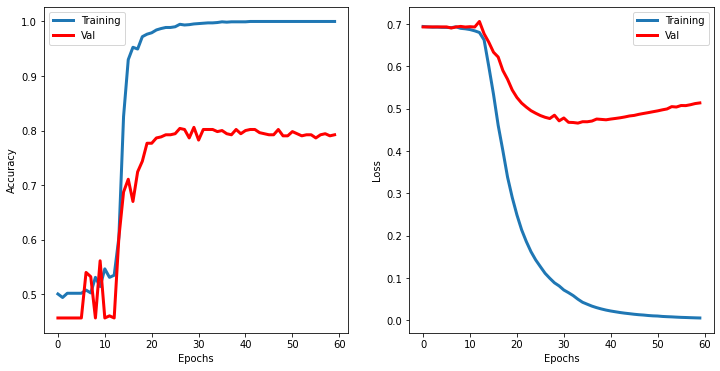

In [97]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(history.history['accuracy'], lw=3, label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Accuracy')
_ = plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(history.history['loss'], lw=3, label='Training')
plt.plot(history.history['val_loss'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Loss')
_ = plt.xlabel('Epochs')

In [98]:
model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 2ms/step - loss: 0.5575 - accuracy: 0.7758


[0.5574514269828796, 0.7758369445800781]

#### Using a single bidirectional LSTM layer

In [99]:
def build_model1():
    embedding_dim = 500
    
    inp = keras.Input(shape=(maxlen))
    
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(inp)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(64, activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [100]:
model = build_model1()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 500)          1927000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               289280    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,224,601
Trainable params: 2,224,601
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = 60,
                    verbose = 0,
                   )

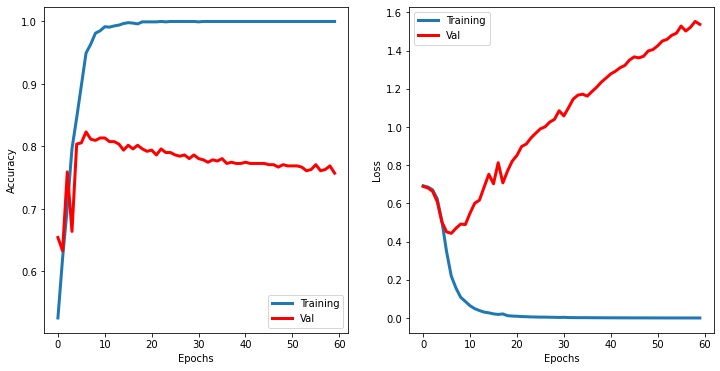

In [102]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(history.history['accuracy'], lw=3, label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Accuracy')
_ = plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(history.history['loss'], lw=3, label='Training')
plt.plot(history.history['val_loss'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Loss')
_ = plt.xlabel('Epochs')

In [103]:
model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 5ms/step - loss: 1.5450 - accuracy: 0.7584


[1.5449841022491455, 0.7583697438240051]

In [104]:
y_pred = model.predict(X_test)

In [105]:
print("Original sentence: ", sentences_test[0])
print("Decoded sentence: ", tokenizer.sequences_to_texts([X_test[0]]))
print("Tokenized vector: ")
print(X_test[0])
print("Predicted output: ", y_pred[0])
print("True output: ", y_test[0])

Original sentence:  This results in the phone being either stuck at max volume or mute.
Decoded sentence:  ['this results in the phone being either at volume or']
Tokenized vector: 
[   6 1559   11    1   26  142  359   30  270   54    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Predicted output:  [1.0374114e-06]
True output:  0


#### Using two bidirectional LSTM layers

In [113]:
def build_model2():
    embedding_dim = 500
    
    inp = keras.Input(shape=(maxlen))
    
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(inp)
    x = layers.Bidirectional(layers.LSTM(64,  return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [114]:
model = build_model2()
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 500)          672500    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          289280    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65  

In [115]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = 30,
                    verbose = 0,
                   )

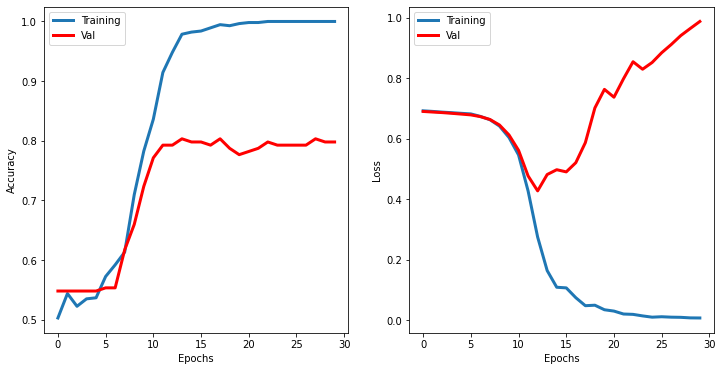

In [116]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(history.history['accuracy'], lw=3, label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Accuracy')
_ = plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(history.history['loss'], lw=3, label='Training')
plt.plot(history.history['val_loss'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Loss')
_ = plt.xlabel('Epochs')

In [117]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 7ms/step - loss: 1.2393 - accuracy: 0.7560


[1.2392956018447876, 0.7559999823570251]

### Step 5: Use pretrained embeddings from GloVe 

(from Deep Learning with Python by Francois Chollet)

In [13]:
word_index = tokenizer.word_index

In [14]:
glove_dir = 'glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [17]:
embedding_dim = 100
max_words = 10000

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### Using a dense layer with no RNN

In [24]:
def build_model3():

    inp = keras.Input(shape=(maxlen))
    
    x = layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen)(inp)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    
    model.layers[1].set_weights([embedding_matrix])
    model.layers[1].trainable = False
    
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [25]:
model = build_model3()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [26]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = 30,
                    verbose = 0,
                   )

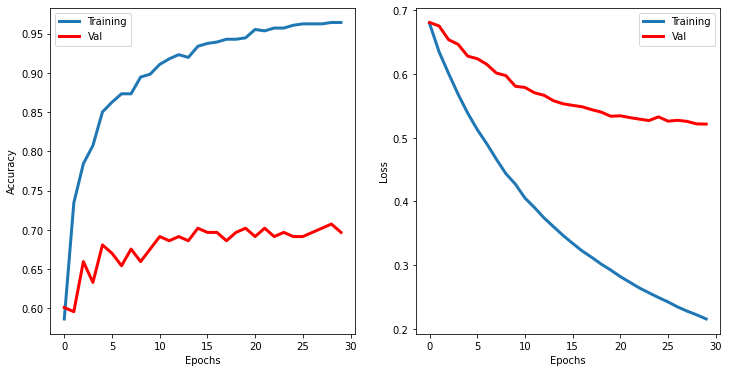

In [27]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(history.history['accuracy'], lw=3, label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Accuracy')
_ = plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(history.history['loss'], lw=3, label='Training')
plt.plot(history.history['val_loss'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Loss')
_ = plt.xlabel('Epochs')

In [28]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 1ms/step - loss: 0.6365 - accuracy: 0.6600


[0.6364844441413879, 0.6600000262260437]

#### Using a single bidirectional LSTM layer

In [29]:
def build_model4():
    
    inp = keras.Input(shape=(maxlen))

    x = layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen)(inp)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(64, activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    
    model.layers[1].set_weights([embedding_matrix])
    model.layers[1].trainable = False
    
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [30]:
model = build_model4()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 1,092,801
Trainable params: 92,801
Non-trainable params: 1,000,000
_________________________________________________________________


In [31]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = 30,
                    verbose = 0,
                   )

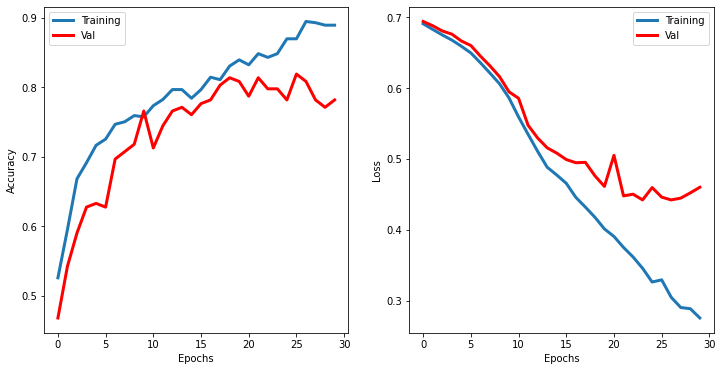

In [32]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(history.history['accuracy'], lw=3, label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Accuracy')
_ = plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(history.history['loss'], lw=3, label='Training')
plt.plot(history.history['val_loss'], 'r', lw = 3, label='Val')
plt.legend()
plt.ylabel('Loss')
_ = plt.xlabel('Epochs')

In [33]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.6840


[0.6697196364402771, 0.6840000152587891]

In [37]:
y_pred = model.predict(X_test)

In [41]:
print("Original sentence: ", sentences_test[0])
print("Decoded sentence: ", tokenizer.sequences_to_texts([X_test[0]]))
print("Tokenized vector: ")
print(X_test[0])
print("Predicted output: ", y_pred[0])
print("True output: ", y_test[0])

Original sentence:  At first I thought I was grtting a good deal at $7.44, until I plugged it into my phone (V3c Razr).
Decoded sentence:  ['at first i thought i was a good deal at 7 i plugged it into my phone razr']
Tokenized vector: 
[ 125   94    2 1125    2   23    7   22  817  125  934    2  970    4
  301   10    9  499    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Predicted output:  [0.44028747]
True output:  0


In [44]:
print("Original sentence: ", sentences_test[1])
print("Decoded sentence: ", tokenizer.sequences_to_texts([X_test[1]]))
print("Tokenized vector: ")
print(X_test[1])
print("Predicted output: ", y_pred[1])
print("True output: ", y_test[1])

Original sentence:  But it does get better reception and clarity than any phone I've had before.
Decoded sentence:  ["but it does get better reception and clarity than any phone i've had before"]
Tokenized vector: 
[ 37   4  59  84  83  88   3 862  49  77   9  42  24 251   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Predicted output:  [0.21133798]
True output:  1
